In [18]:
%matplotlib inline
import json
import collections
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from statsmodels.nonparametric.kernel_regression import KernelReg


In [19]:
def extract_data(fname):
    if not os.path.exists(fname):
        return None
    time_li = []
    mem_li = []
    with open(fname, 'r') as f:
        for line in f.readlines():
            time = float(line.split(" ")[4])
            mem = float(line.split(" ")[5])
            time_li.append(time)
            mem_li.append(mem)
    if len(time_li) == 0:
        return None
    time_avg = sum(time_li) / len(time_li)
    mem_avg = sum(mem_li) / len(mem_li)
    return {"time": time_avg, "mem": mem_avg}

def extract_data_hypre(fname):
    if not os.path.exists(fname):
        return None
    time_li = []
    mem_li = []
    with open(fname, 'r') as f:
        for line in f.readlines():
            if "hypre" not in line:
                try:
                    time = float(line.split(" ")[4])
                    mem = float(line.split(" ")[5])
                    time_li.append(time)
                    mem_li.append(mem)
                except:
                    continue
    if len(time_li) == 0:
        return None
    time_avg = sum(time_li) / len(time_li)
    mem_avg = sum(mem_li) / len(mem_li)
    return {"time": time_avg, "mem": mem_avg}

def extract_data_trilinos(fname):
    if not os.path.exists(fname):
        return None
    time_li = []
    mem_li = []
    with open(fname, 'r') as f:
        for line in f.readlines():
            if "[BOS]" in line:
                time = float(line.split(" ")[0].strip("[BOS]").strip("[EOS]"))
                mem = float(line.split(" ")[1])
                time_li.append(time)
                mem_li.append(mem)
    if len(time_li) == 0:
        return None
    time_avg = sum(time_li) / len(time_li)
    mem_avg = sum(mem_li) / len(mem_li)
    return {"time": time_avg, "mem": mem_avg}

def get_mat_sz(fp):
    try:
        # the first 8 values are: dim, is_spd, is_sequence, nrow, ncol, nnz, outer_sz, inner_sz
        meta = np.fromfile(fp, dtype=np.int32, count=8, offset=0)
        n_rows = meta[3]
        return n_rows
    except:
        print("mat size exception")
        return None

def get_nnz(fp):
    try:
        meta = np.fromfile(fp, dtype=np.int32, count=8, offset=0)
        nnz = meta[5]
        return nnz
    except:
        print("nnz exception")
        return None

def get_density(nnz, mat_sz):
    if nnz is None or mat_sz is None:
        return None
    else:
        return nnz / (mat_sz * mat_sz)

def get_sparsity(nnz, mat_sz):
    if nnz is None or mat_sz is None:
        return None
    else:
        return (mat_sz * mat_sz - nnz) / (mat_sz * mat_sz)

def sheet_all(data_dir, mat_dir, result_dir, save_dir, solver_list):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    with open(os.path.join(data_dir, "filenames.json"), "r") as f:
        filenames = json.load(f)
        prenames = filenames["prenames"]
        fpaths = filenames["fpaths"]

    data_all = {}
    for solver in solver_list:
        data_all[solver] = []
    for fpath, prename in zip(fpaths, prenames):
        for solver in solver_list:
            fp = "%s/%s/%s.log" % (result_dir, solver, prename)
            if solver == "Trilinos" or solver == "Trilinos-nullspace":
                avg_data = extract_data_trilinos(fp)
            elif solver == "Hypre":
                avg_data = extract_data_hypre(fp)
            else:
                avg_data = extract_data(fp)
            if avg_data is None:
                avg_data = {'time': 0.0, 'mem': 0.0}
            avg_data["time"] = avg_data["time"] * 1000  # convert sec to ms
            avg_data["fpath"] = fpath
            avg_data["prename"] = prename
            avg_data["mat_sz"] = get_mat_sz(os.path.join(mat_dir, prename, "1_1_A.bin"))
            avg_data["nnz"] = get_nnz(os.path.join(mat_dir, prename, "1_1_A.bin"))
            avg_data["density"] = get_density(avg_data["nnz"], avg_data["mat_sz"])
            avg_data["sparsity"] = get_sparsity(avg_data["nnz"], avg_data["mat_sz"])
            data_all[solver].append(avg_data)
    
    columns = ["prename", 
               "fpath",     
               "mat_sz",
               "nnz",
               "density",
               "sparsity",
               "time",
               "mem"]

    writer = pd.ExcelWriter(os.path.join(save_dir, 'profiling.xlsx'))
    for solver in solver_list:
        df0 = pd.DataFrame(data_all[solver], columns=columns)
        df0.to_excel(writer, sheet_name=solver)
    writer.close()

    return data_all

def process_data(data_all, solver, x_attr, y_attr, flt_msz=None, ratio=False):
    if ratio:
        data = pd.DataFrame(data_all["Pardiso"], columns=["prename", x_attr, y_attr])
        y_baseline = data[y_attr].values.tolist()
        y_baseline = np.array(y_baseline)

    data = pd.DataFrame(data_all[solver], columns=["prename", x_attr, y_attr])

    x_li = data[x_attr].values.tolist()
    y_li = data[y_attr].values.tolist()
    prename_li = data["prename"].values.tolist()
    
    x = np.array(x_li)
    y = np.array(y_li)
    prename_arr = np.array(prename_li)

    if ratio:
        epsilon = 1e-50
        y = (y_baseline+epsilon) / (y+epsilon)


    # Filter NaN values
    x_nan_idx = np.argwhere(np.isnan(x)).squeeze()
    y_nan_idx = np.argwhere(np.isnan(y)).squeeze()
    nan_idx = np.union1d(x_nan_idx, y_nan_idx)
    x = np.delete(x, nan_idx)
    y = np.delete(y, nan_idx)
    prename_arr = np.delete(prename_arr, nan_idx)
    
    # Filter by matrix size if specified
    if flt_msz is not None:
        x_small_idx = np.argwhere(x < flt_msz).squeeze()
        print(x_small_idx)
        x = x[x_small_idx]
        y = y[x_small_idx]
        prename_arr = prename_arr[x_small_idx]
    
    # Sort the arrays
    sorted_id = sorted(range(len(x)), key=lambda k: x[k], reverse=True)
    x_sort = x[sorted_id]
    y_sort = y[sorted_id]
    prename_sort = prename_arr[sorted_id]

    return x_sort, y_sort, prename_sort

def plot(solver_list, data_all, x_attr, y_attr, x_label, y_label, log=True, ratio=False, flt_msz=None, title=None, save_path=None):
    # Create a new figure each time this function is called
  
    plt.figure(figsize=(15,10))
    plt.title(title)
    ax = plt.gca()

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid()

    # Apply log scale if specified
    if log:
        ax.set_yscale("log", base=2, subs=[])
        ax.set_xscale("log", base=2, subs=[])

    colors = ["r", "b", "g", "grey", "brown"]
    i = 0

    for solver in solver_list:
        x_sort, y_sort, prename_sort = process_data(data_all, solver, x_attr, y_attr, flt_msz, ratio)

        # Plot original data
        ax.plot(x_sort, y_sort, "-", color=colors[i], linewidth=1, alpha=0.4, label=solver)
        ax.plot(x_sort, y_sort, "o", color=colors[i], linewidth=1, alpha=0.4)

#         if len(x_sort) > 3:
#             coefficients = np.polyfit(x_sort, y_sort, deg=3)
#             poly_fit = np.poly1d(coefficients)
#             y_fit = poly_fit(x_sort)
#             ax.plot(x_sort, y_fit, "--", color=colors[i], linewidth=2, label=f"{solver} poly fit")
#         else:
#             print(f"Not enough data points for polynomial regression for {solver}")
            
        kr = KernelReg(endog=y_sort, exog=x_sort, var_type='c')
        y_fit, _ = kr.fit(x_sort)

        # Plot the smoothed trend line
#         ax.plot(x_sort, y_fit, "--", color=colors[i], linewidth=2, label=f"{solver} Gaussian fit")

        i += 1

    plt.legend()

    if save_path is not None:
        plt.savefig(save_path)
    plt.show()


In [20]:
# Set your directories accordingly
# Please adjust the following paths as needed
data_dir = "/home/yibo/myrepo/exp-data/data-all"
mat_dir = "/u/3/yibo/exp-result/0808-old/solver-mat"
result_dir = "/u/3/yibo/exp-result/0808-old"
save_dir = "/home/yibo/myrepo/ExpPolySolve/output_test"
solver_list = ["Pardiso", "Trilinos", "Trilinos-nullspace", "AMGCL", "Hypre"]

# Generate profiling data and save to Excel
data_all = sheet_all(data_dir, mat_dir, result_dir, save_dir, solver_list)

mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size exception
nnz exception
mat size e

/tmp/ipykernel_3108744/254457752.py:80: RuntimeWarning: overflow encountered in scalar multiply
  return nnz / (mat_sz * mat_sz)
/tmp/ipykernel_3108744/254457752.py:86: RuntimeWarning: overflow encountered in scalar multiply
  return (mat_sz * mat_sz - nnz) / (mat_sz * mat_sz)


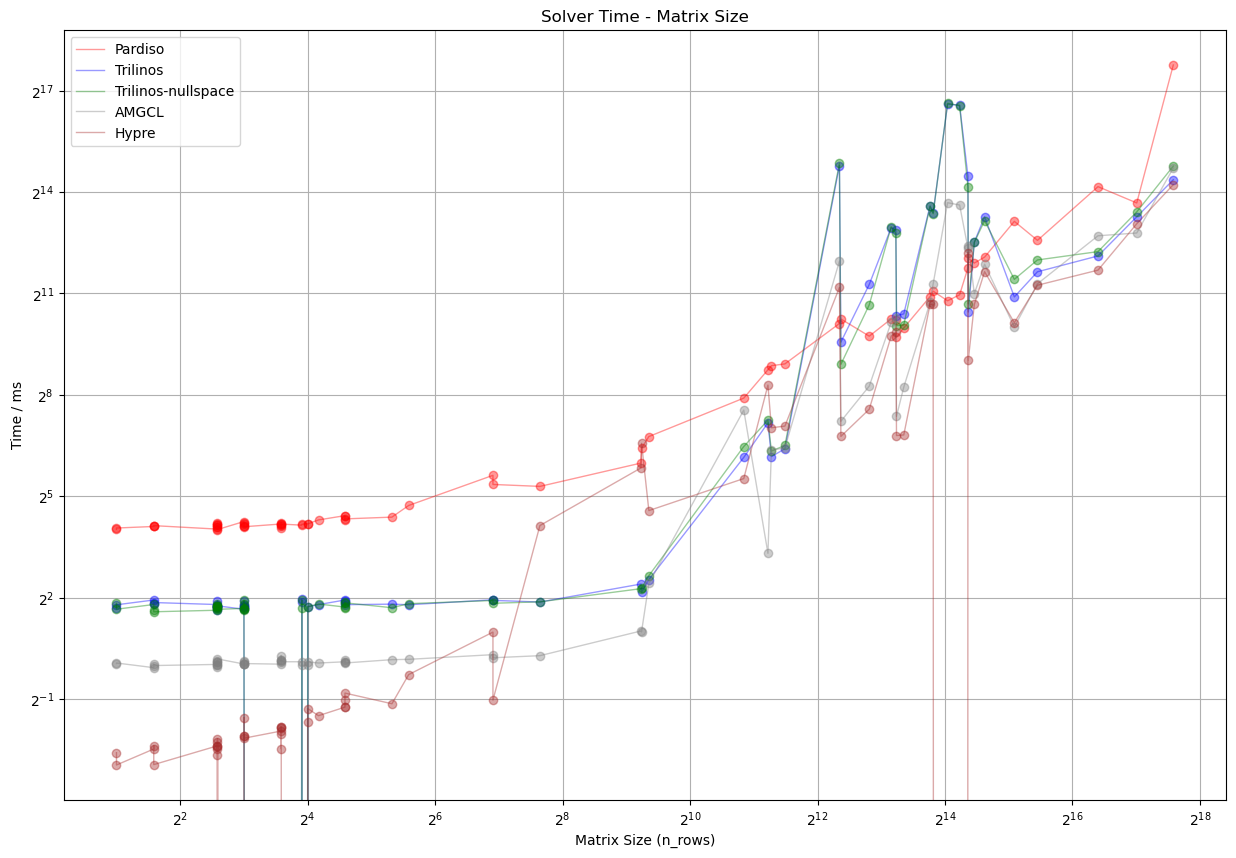

In [9]:
# Plot figures
plot(solver_list, data_all, x_attr="mat_sz", y_attr="time", 
     x_label="Matrix Size (n_rows)", y_label="Time / ms", 
     log=True, ratio=False, flt_msz=None, 
     title="Solver Time - Matrix Size", 
     save_path=os.path.join(save_dir, "time_n.png"))


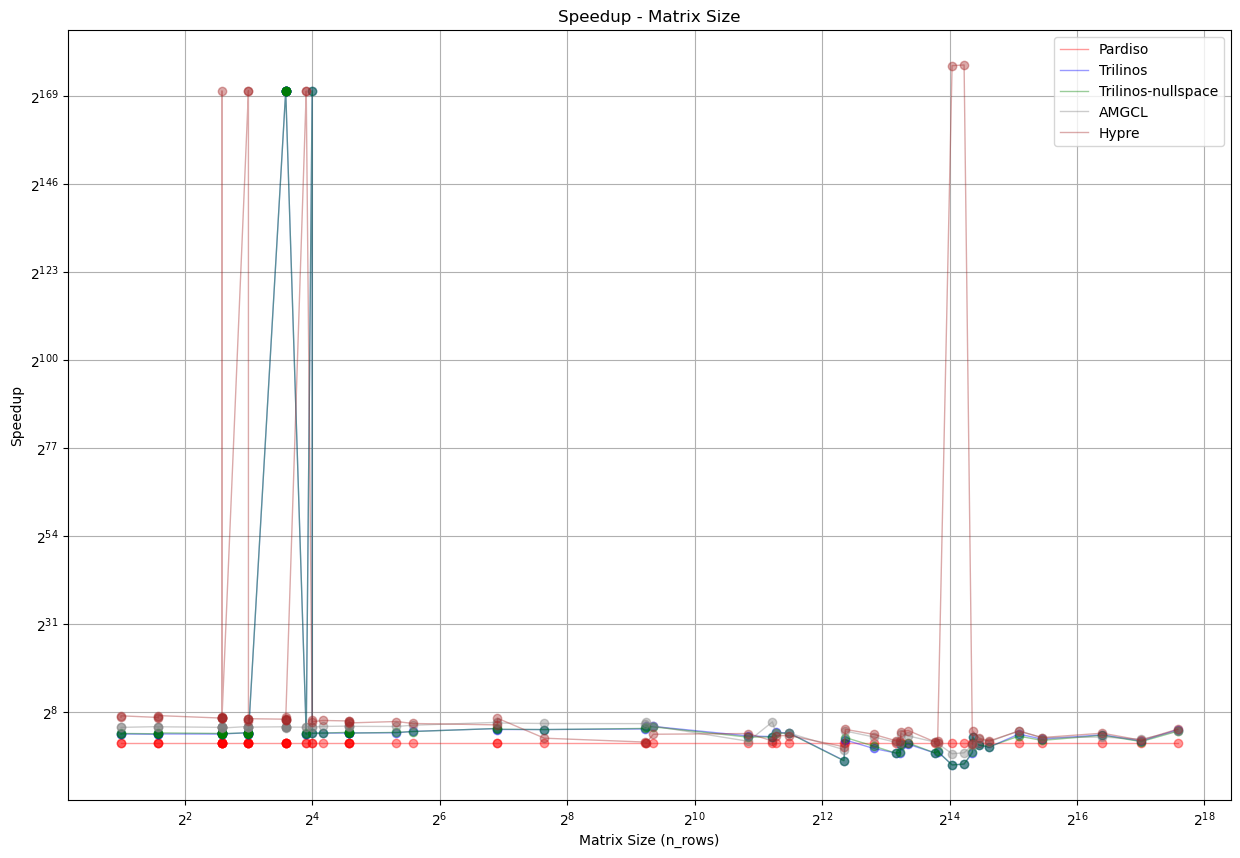

In [10]:
plot(solver_list, data_all, x_attr="mat_sz", y_attr="time", 
     x_label="Matrix Size (n_rows)", y_label="Speedup", 
     log=True, ratio=True, flt_msz=None, 
     title="Speedup - Matrix Size", 
     save_path=os.path.join(save_dir, "speedup_n.png"))

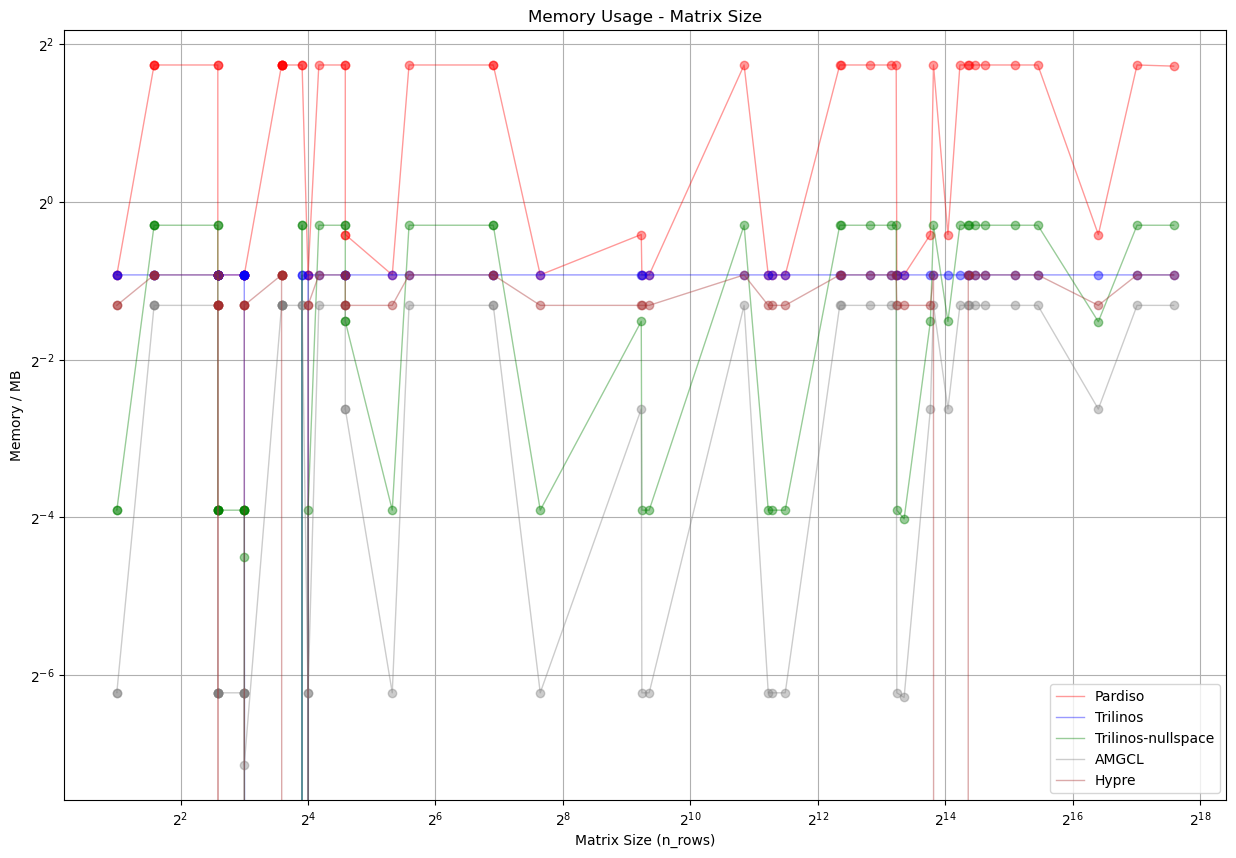

In [11]:
plot(solver_list, data_all, x_attr="mat_sz", y_attr="mem", 
     x_label="Matrix Size (n_rows)", y_label="Memory / MB", 
     log=True, ratio=False, flt_msz=None, 
     title="Memory Usage - Matrix Size", 
     save_path=os.path.join(save_dir, "mem_n.png"))

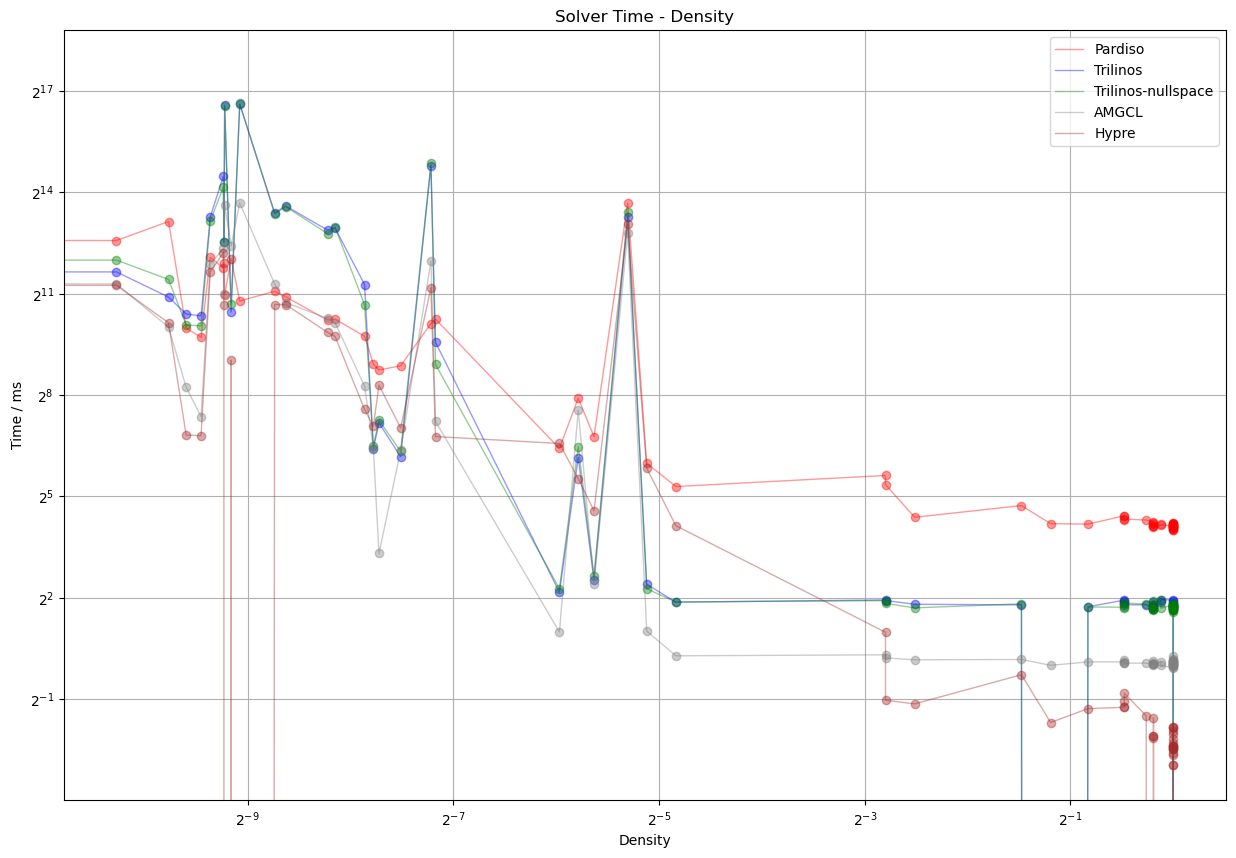

In [12]:

plot(solver_list, data_all, x_attr="density", y_attr="time", 
     x_label="Density", y_label="Time / ms", 
     log=True, ratio=False, flt_msz=None, 
     title="Solver Time - Density", 
     save_path=os.path.join(save_dir, "time_d.png"))


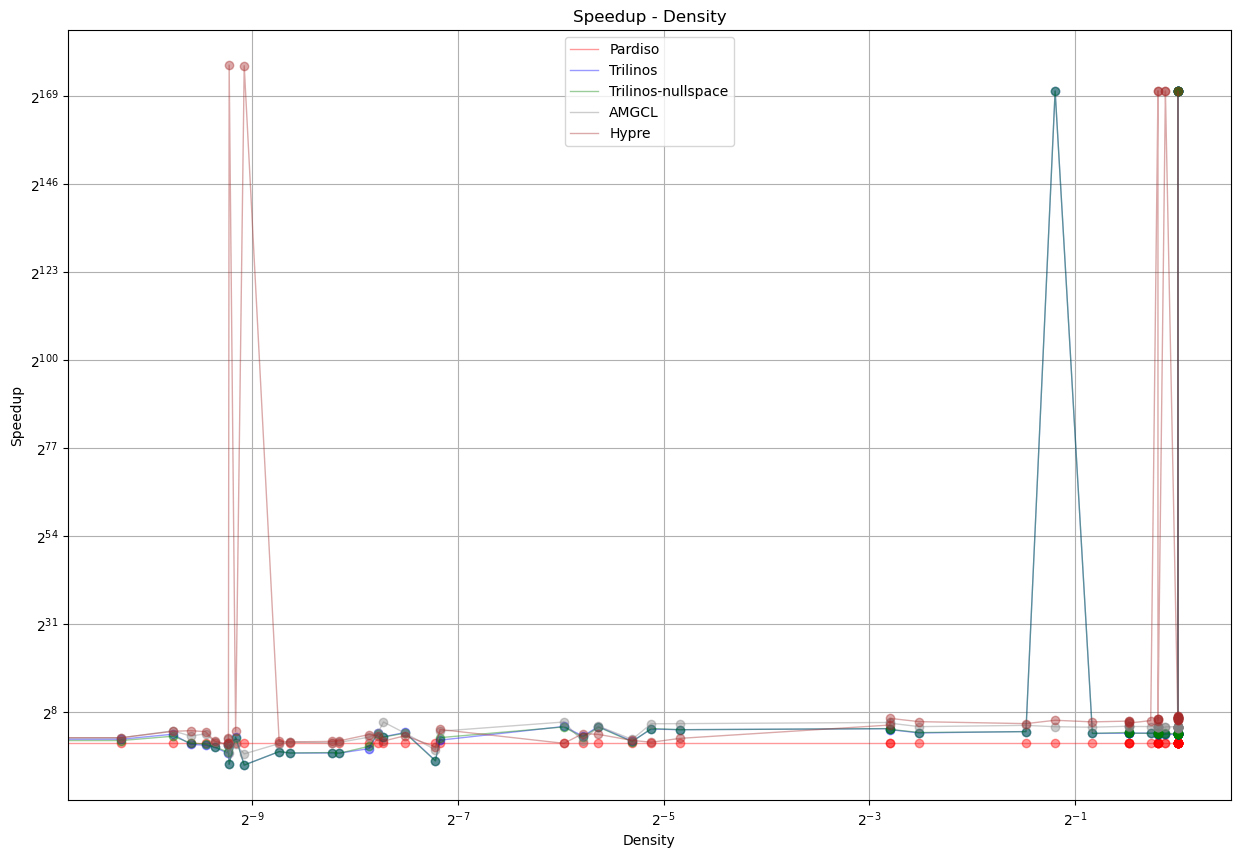

In [13]:
plot(solver_list, data_all, x_attr="density", y_attr="time", 
     x_label="Density", y_label="Speedup", 
     log=True, ratio=True, flt_msz=None, 
     title="Speedup - Density", 
     save_path=os.path.join(save_dir, "speedup_d.png"))

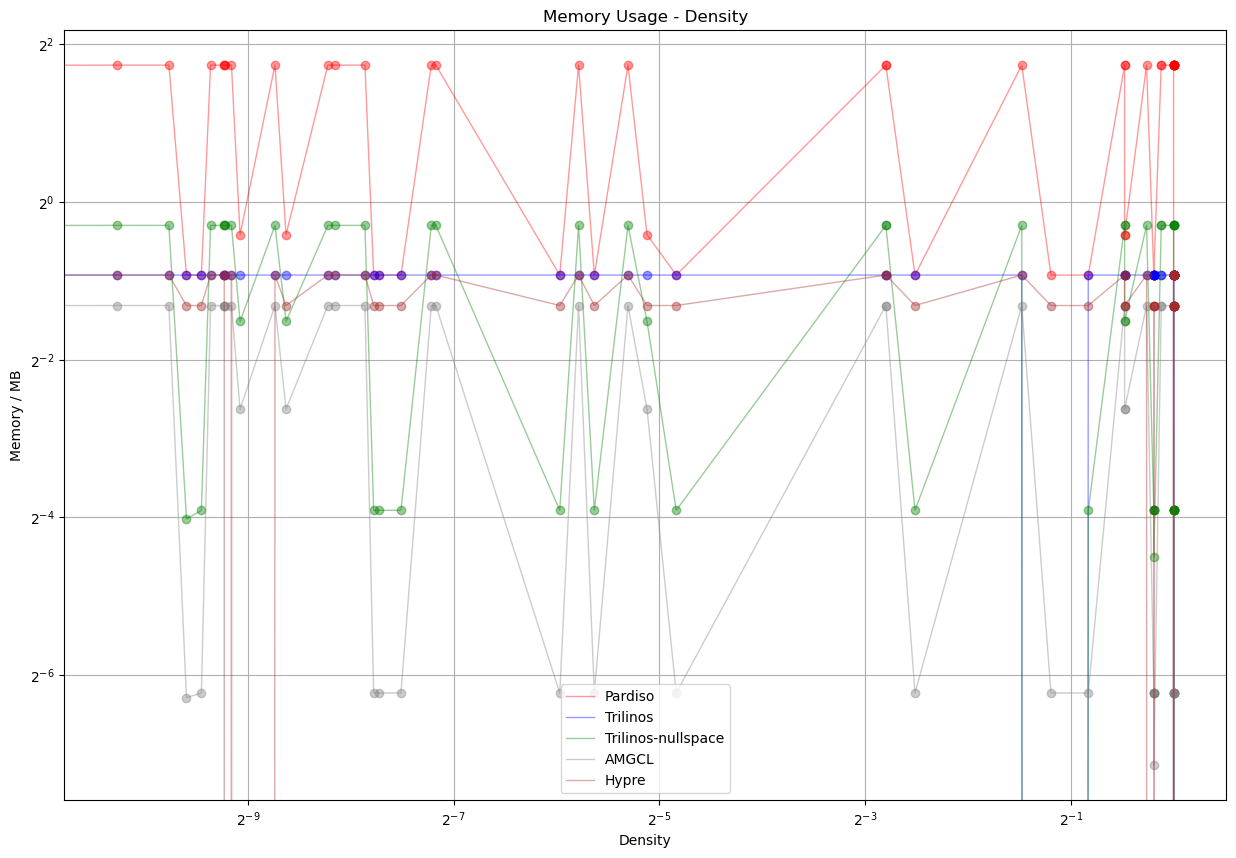

In [14]:
plot(solver_list, data_all, x_attr="density", y_attr="mem", 
     x_label="Density", y_label="Memory / MB", 
     log=True, ratio=False, flt_msz=None, 
     title="Memory Usage - Density", 
     save_path=os.path.join(save_dir, "mem_d.png"))

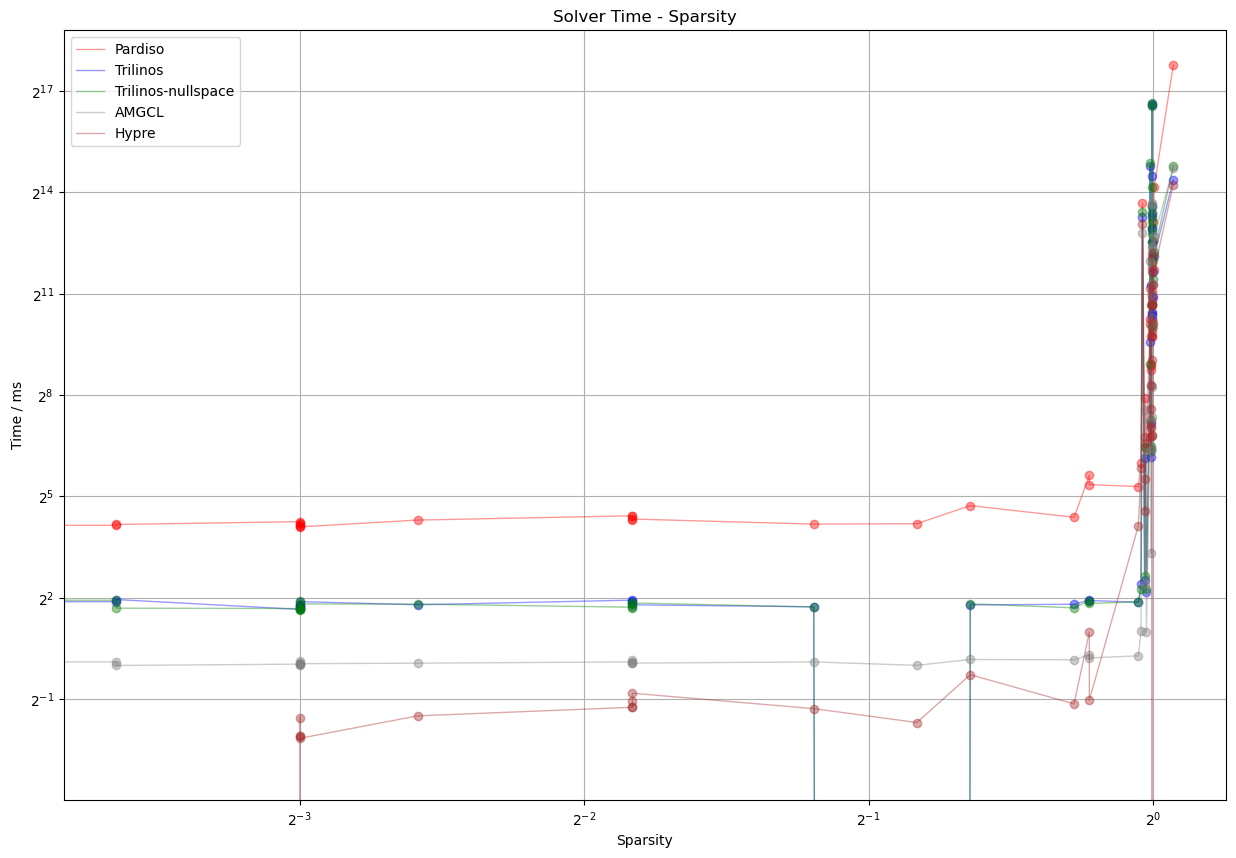

In [15]:
# If you want to plot sparsity-based figures, uncomment the following lines:
plot(solver_list, data_all, x_attr="sparsity", y_attr="time", x_label="Sparsity", y_label="Time / ms", log=True, ratio=False, flt_msz=None, title="Solver Time - Sparsity", save_path=os.path.join(save_dir, "time_s.png"))

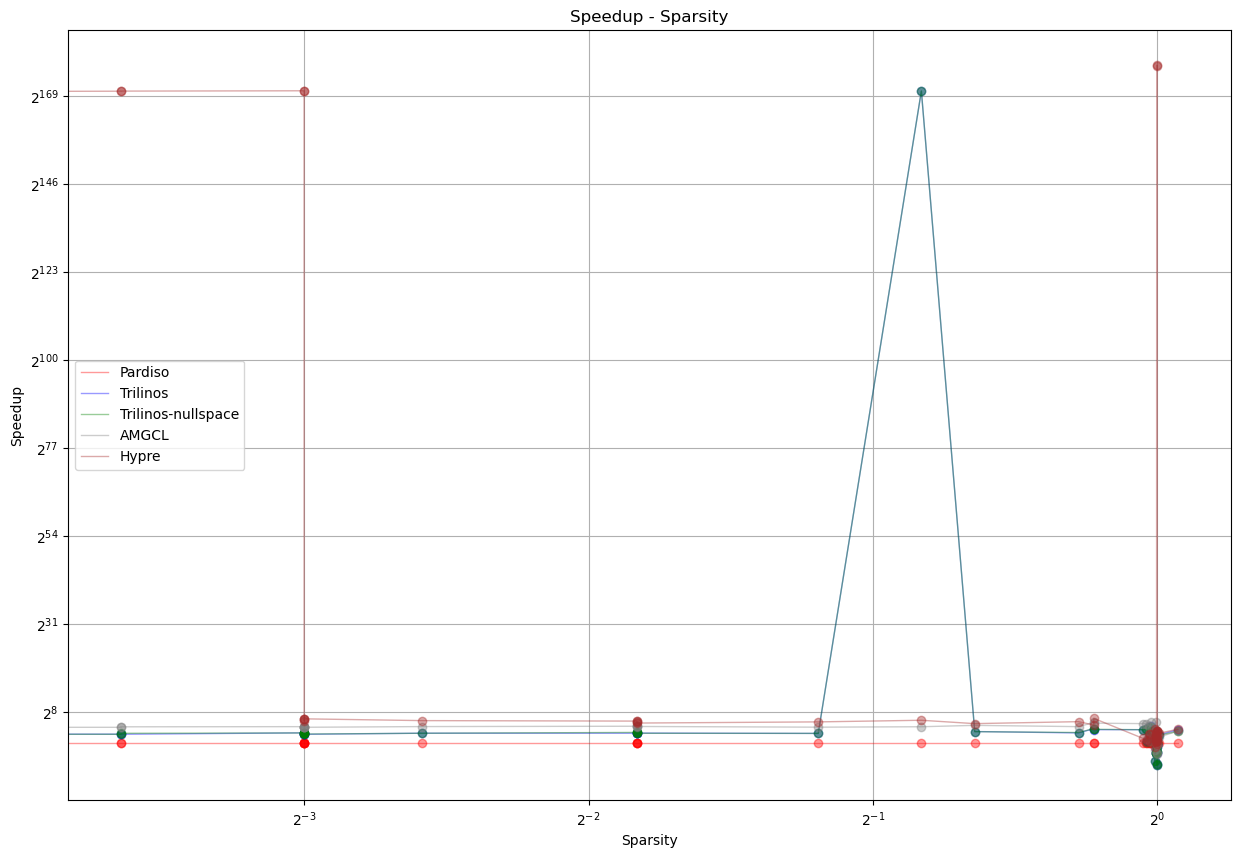

In [16]:
plot(solver_list, data_all, x_attr="sparsity", y_attr="time", x_label="Sparsity", y_label="Speedup", log=True, ratio=True, flt_msz=None, title="Speedup - Sparsity", save_path=os.path.join(save_dir, "speedup_s.png"))


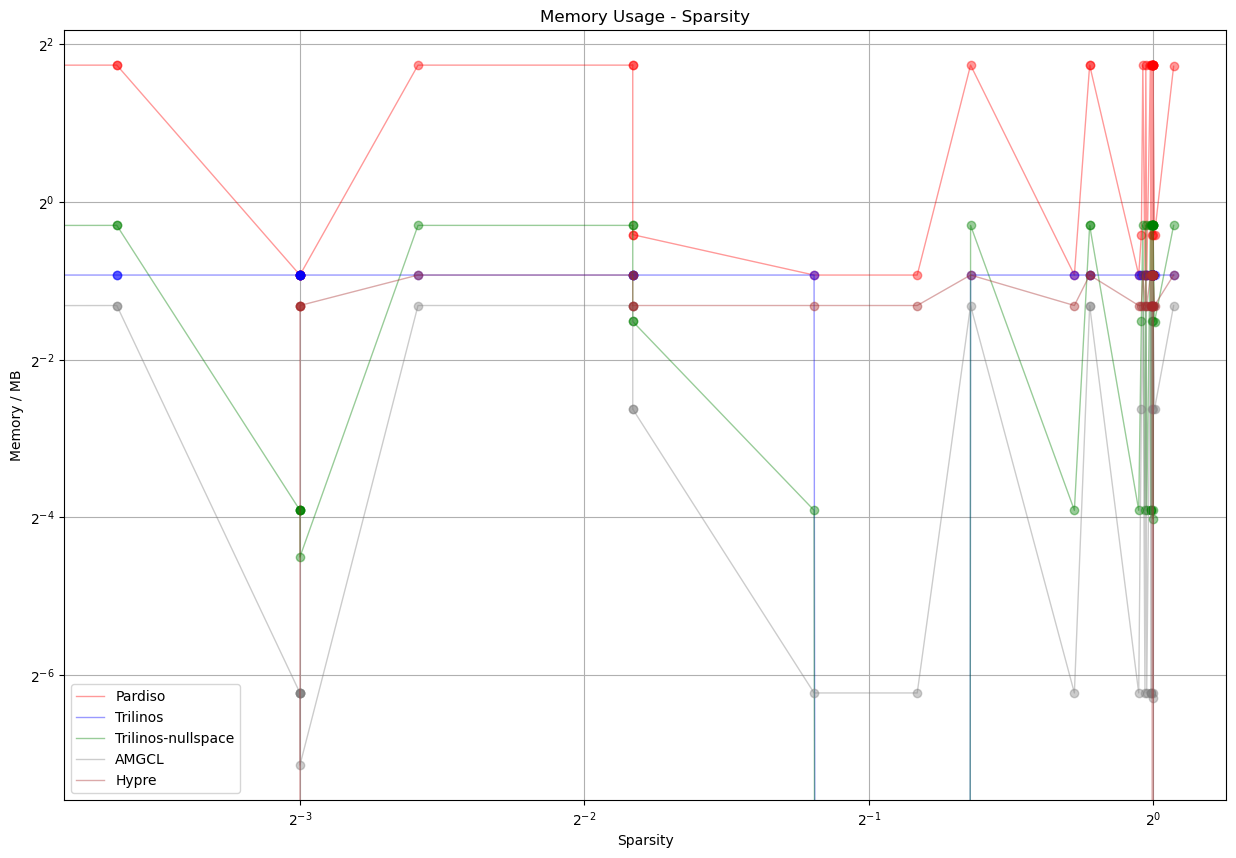

In [17]:
plot(solver_list, data_all, x_attr="sparsity", y_attr="mem", x_label="Sparsity", y_label="Memory / MB", log=True, ratio=False, flt_msz=None, title="Memory Usage - Sparsity", save_path=os.path.join(save_dir, "mem_s.png"))
